# 3. 뉴스 요약봇 만들기
---
* 데이터 준비하기
* 데이터 전처리하기 (1) 데이터 정리하기
* 데이터 전처리하기 (2) 훈련 데이터와 테스트 데이터 나누기
* 데이터 전처리하기 (3) 정수 인코딩
* 모델 설계하기
* 모델 훈련하기
* 인퍼런스 모델 구현하기
* 모델 테스트하기
* 추출적 요약해보기

## 데이터 준비하기
---
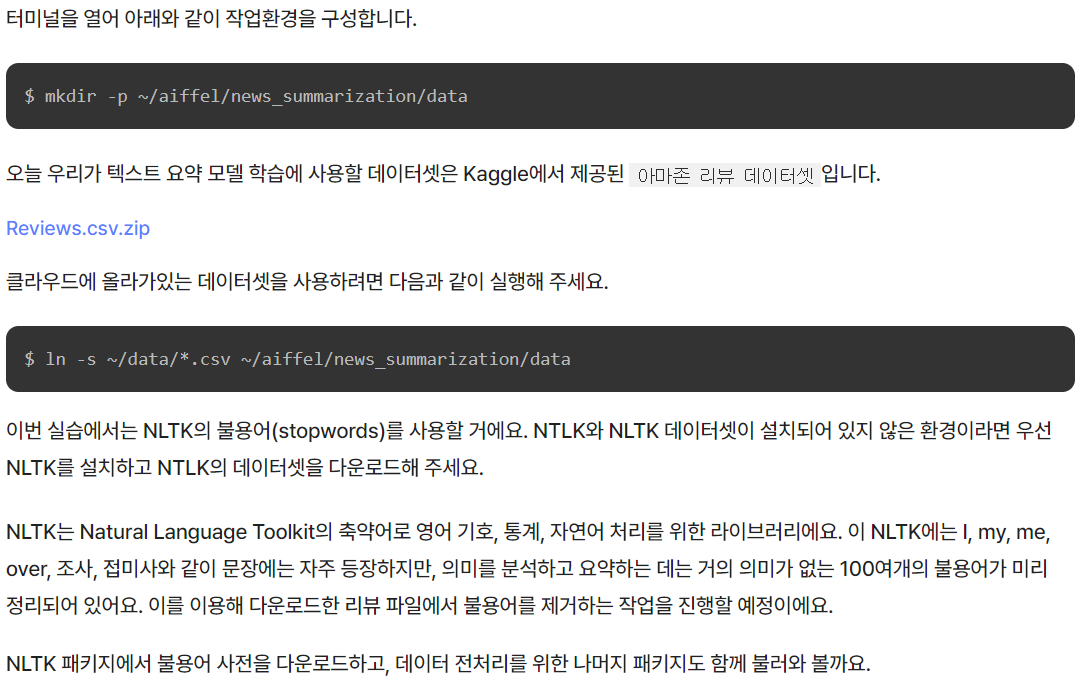

In [2]:
# 라이브러리 및 모듈, 함수 등 불러오기
import nltk # nltk 라이브러리 불러오기
nltk.download('stopwords') # nltk 패키지에서 불용어 사전을 다운로드

import numpy as np # numpy 라이브러리 불러오기
import pandas as pd # pandas 라이브러리 불러오기
import os # os 모듈 불러오기
import re  # re 모듈 불러오기
import matplotlib.pyplot as plt # pyplot 모듈 불러오기
from nltk.corpus import stopwords # stopwords 불용어 사전 불러오기
from bs4 import BeautifulSoup # BeautifulSoup 모듈 불러오기
from tensorflow.keras.preprocessing.text import Tokenizer # Tokenizer 모듈 불러오기
from tensorflow.keras.preprocessing.sequence import pad_sequences # pad_sequences 함수 불러오기
import urllib.request # urllib을 사용하여 웹 페이지나 URL로부터 데이터를 가져오는 기능을 제공
import warnings # warnings 모듈을 사용하여 경고를 무시
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


링크에서 다운로드 받은 데이터(Reviews.csv)는 총 568,454개의 샘플을 갖고 있다. 시간상 여기서는 모든 샘플을 사용하지는 않고, 간단히 10만 개의 샘플만 사용해보자.

In [3]:
# 10만 개의 샘플만 불러오기
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000) # 10만 개의 행만 읽어와 데이터로 변환, 
                                                                                                 # pandas의 read_csv 함수를 사용하여 데이터프레임으로 읽어오기
print('전체 샘플수 :', (len(data))) # 데이터의 개수(행의 개수)를 세어준다.

전체 샘플수 : 100000


In [4]:
# 10만 개의 샘플 중 5개만 출력해보기
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Summary 열과 Text 열만 훈련에 사용되므로, 이 두 개의 열만 별도로 저장하고, 다시 출력해보자.

In [5]:
# 데이터프레임 data의 Text와 Summary 컬럼의 데이터만 남기자
data = data[['Summary', 'Text']] # data 데이터프레임에서 Summart와 Text 열만 data 함수에 할당
data.head() # 5개 샘플 보기

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
# 랜덤한 15개 샘플 출력
data.sample(15)

,Summary,Text
91137,Yummy Yummy,This mustard is fantastic (and I don't even re...
51358,Good value over store bought.,"Originally, we bought pkts from the grocery st..."
3346,Should have listened to other bad reviews :(,I wish I had listened to the other bad reviews...
8006,Koma is delicious,I don't drink soda and have no interest in ene...
16692,Carbonated kiwi juice in a can,I did not find this drink special in terms of ...
99242,Used to help increase milk supply while breast...,I purchased this item because my OBGYN recomme...
47067,FROMM SURF&TURF,My dogs love this stuff. I was currently on Ta...
38947,best ever rye flavor,"a great rye product for a tasty, great-crumb l..."
12031,EEEWWWW,These flavors are so realistic! The rotten egg...
1067,Too pricey,"It's a good idea to have raw sugar type cubes,..."


**Text 열의 내용을 요약한 것이 Summary 열이다. 인공 신경망을 통해 Text 시퀀스를 입력받으면, Summary 시퀀스를 예측하도록 인공 신경망을 훈련시켜 보자.**

## 데이터 전처리하기 (1) 데이터 정리하기
---

빈칸으로 존재하는 null 데이터, 의미는 같지만 다른 식으로 작성된 글 같은 중복 항목과 같은 학습할 때 방해가 되는 데이터를 먼저 솎아내자.

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [7]:
# 데이터의 중복 샘플 유무 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique()) # 해당 열의 중복되지 않은 값의 개수를 반환
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique()) # 해당 열의 중복되지 않은 값의 개수를 반환

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


데이터프레임의 drop_duplicates()를 사용하여, 손쉽게 중복 샘플을 제거

In [8]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True) # True로 설정할 경우, 새로운 데이터프레임을 반환하지 않고, 해당 데이터프레임의 내용을 직접 변경
                                                      # False로 설정할 경우, 기본적으로 새로운 데이터프레임을 반환하고 원본은 변경하지 않음
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


중복이 제거되면서 샘플 수가 88,426개로 줄어들었다. 그런데 만약 데이터 Null 값을 가지는 샘플이 있었다면, drop_duplicates()가 중복된 Null들을 지워주기는 하겠지만, 여전히 Null 값 한 개가 어딘가 남아있을 수 있다. 데이터에 Null 값이 남아있는지 보자.

In [9]:
# 데이터프레임에 Null 값이 있는지 확인
print(data.isnull().sum())

Summary    1
Text       0
dtype: int64


In [10]:
# Summary에 있는 Null 값을 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88425


전체 샘플 수가 1개 줄어들어 88,425개의 샘플이 남았다. 지금까지 중복 샘플과 Null 값이 있는 샘플들을 제거해보았는데 10만 개의 샘플 중 1만 개 이상의 샘플이 제거되었다.

### 텍스트 정규화와 불용어 제거
---
살아남은 88,425개의 샘플에는 수많은 단어들이 있다. 그런데 사실 그 단어들 중에서는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있다.

예를 들어서 it'll은 it will과 같고, mustn't과 must not은 사실 같은 표현이다. 이런 경우 기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법이다.

이러한 방법론을 텍스트 처리에서는 **텍스트 정규화(text normalization)** 라고 한다.

여기서는 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성할 것이다. 이 사전은 아래의 링크에서 참고하여 만들었다.

https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [11]:
# 텍스트 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재한다. 이를 불용어(stopwords)라고 부른다. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있으므로, 여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거하자.

In [12]:
print('불용어 개수 :', len(stopwords.words('english') )) # 영어 불용어 목록에 포함된 불용어의 개수를 세어 출력
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개라는 것을 볼 수 있다. 이를 사용하여 불용어를 제거할 것이다. 

이 작업 외에도 

* 모든 영어 문자는 소문자로 만들고, 
* 섞여있는 html 태그를 제거하고, 
* 정규 표현식을 통해 각종 특수문자를 제거해서 

정말 필요한 내용만 잘 학습할 수 있도록 처리할 것이다.

함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않을 예정이다. Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Summary에는 남아 있는 게 더 좋을 것 같다. 이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문을 추가했다.

In [13]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


In [14]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


* 결과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고, <br />과 같은 html 태그가 제거되었다. 
* (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있다. 
* 또한 특수문자가 제거되면서 영어만 남았다.

이제 함수가 잘 작동하는 것을 확인했으니, 훈련 데이터 전체에 대해서 전처리를 수행해보자. 이때, Text의 경우에는 불용어를 제거하고, Summary의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야 한다. 먼저 Text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해보자

In [15]:
# 훈련 데이터 전체의 Text 컬럼의 데이터를 전처리하는 코드를 작성 (반복문 사용)
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
clean_text = []

for s in data['Text']: # Text 열의 행마다의 문장들을 뽑아준다.
    clean_text.append(preprocess_sentence(s)) # 그 문장들을 preprocess_sentence 함수를 사용하여 전처리 해준 후, clean_text 리스트에 넣는다.

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']


In [16]:
# 훈련 데이터 전체의 Summary 컬럼의 데이터를 전처리하는 코드를 작성 (반복문 사용)
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
clean_summary = []

for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']


이렇게 텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인해보는 것이 좋다. 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있다. 이렇게 되면 샘플 자체가 빈 값을 가지게 된다.

보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장한다. 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체한다.

In [17]:
data['Text'] = clean_text # 데이터를 데이터프레임에 재저장
data['Summary'] = clean_summary # 데이터를 데이터프레임에 재저장

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [18]:
# Null 값이 생겼는지 확인
data.isnull().sum()

Summary    70
Text        0
dtype: int64

Summary 열에서 70개의 Null 값이 생겼다. 원래는 단어가 있었는데, 정제 과정에서 모든 단어가 제거되어 빈 샘플이 70개나 생겼다는 의미이다. 이 샘플들은 모두 제거해주자.

In [19]:
# 빈 샘플 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


## 데이터 전처리하기 (2) 훈련데이터와 테스트데이터 나누기
---
학습을 진행하기 위해 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시해 줘야 한다.

### 샘플의 최대 길이 정하기
---
필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례이다.

Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해보자.

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


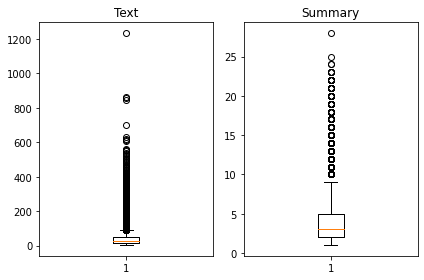

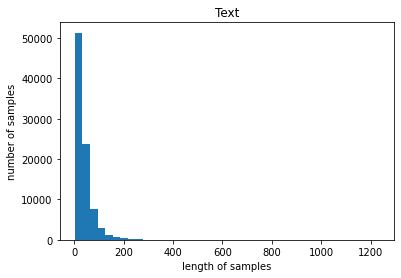

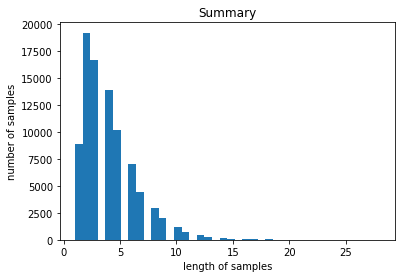

In [20]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']] # Text 데이터 행마다의 문장 길이를 리스트에 나열
summary_len = [len(s.split()) for s in data['Summary']] # Summary 데이터 행마다의 문장 길이를 리스트에 나열

print('텍스트의 최소 길이 : {}'.format(np.min(text_len))) # 가장 짧은 문장 길이
print('텍스트의 최대 길이 : {}'.format(np.max(text_len))) # 가장 긴 문장 길이
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len))) # Text 데이터 문장의 길이들의 평균
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40) # Text열의 문장 길이를 히스토그램으로 시각화, bins=40은 히스토그램 막대의 개수를 지정
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40) # Summary열의 문장 길이를 히스토그램으로 시각화, bins=40은 히스토그램 막대의 개수를 지정
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프처럼, 많은 양의 데이터를 다룰 때는 데이터를 시각화하여 보는 것이 도움이 된다. 

위에서부터 차례대로 그래프는 각각 실제 텍스트와 요약의 길이 분포, 실제 텍스트 샘플 길이별 개수, 요약본 샘플 길이별 개수를 나타내고 있다.

Text의 경우 최소 길이가 2, 최대 길이가 1,235로 그 차이가 굉장히 크다. 하지만 평균 길이는 38로 시각화된 그래프로 봤을 때는 대체적으로는 100 내외의 길이를 가진다는 것을 확인할 수 있다.

Summary의 경우 최소 길이가 1, 최대 길이가 28, 그리고 평균 길이가 4로 Text에 비해 상대적으로 길이가 매우 짧다. 그래프로 봤을 때에도 대체적으로 10이하의 길이를 가지고 있다.

이로부터 Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정해보자.

In [21]:
text_max_len = 50
summary_max_len = 8
print('=3')

=3


각각 50과 8로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 될 것이다. 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해보자.

In [22]:
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터가 몇 %가 해당하는지 계산하는 함수
def below_threshold_len(max_len, nested_list): 
  cnt = 0
  for s in nested_list: # 데이터의 행들을 하나씩 뽑아줌
    if(len(s.split()) <= max_len): # 뽑은 데이터를 공백을 기준으로 단어의 개수를 세고, 입력한 샘플의 길이 이하인 경우
        cnt = cnt + 1 # 1씩 더해서 개수를 센다.
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [23]:
# below_threshold_len 함수를 Text와 Summary에 적용하여, 결정한 임의의 길이가 몇 % 샘플까지 포함하는지 보자
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


각각 50과 8로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데, Text 열의 경우에는 약 23%의 샘플들이 내용이 망가지게 된다고 한다.

우리는 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제해보도록 하자.

In [24]:
# Text와 Summary를 담고 있는 data 데이터프레임을 위에서 임의로 정의한 text_max_len과 summary_max_len의 길이보다 큰 샘플을 제외하는 코드
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


### 시작 토큰과 종료 토큰 추가하기
---
앞서 시작 토큰과 종료 토큰에 대해서 언급했던 것을 기억해보면, 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 것이었다.
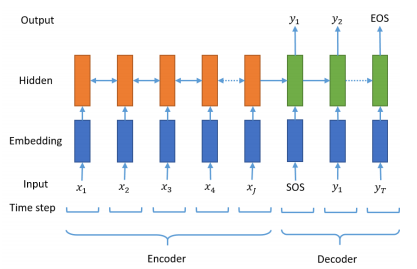
[시작 토큰 SOS와 종료 토큰 EOS는 각각 start of a sequence와 end of a sequence를 나타낸다]

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있다. 이번 실습에서는 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가할 것이다. 

디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정했다. 두 개의 문장 모두 Summary 열로부터 만들 것이다.

In [25]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Summary,Text,decoder_input,decoder_target
0,good quality dog food,bought several vitality canned dog food produc...,sostoken good quality dog food,good quality dog food eostoken
1,not as advertised,product arrived labeled jumbo salted peanuts p...,sostoken not as advertised,not as advertised eostoken
2,delight says it all,confection around centuries light pillowy citr...,sostoken delight says it all,delight says it all eostoken
3,cough medicine,looking secret ingredient robitussin believe f...,sostoken cough medicine,cough medicine eostoken
4,great taffy,great taffy great price wide assortment yummy ...,sostoken great taffy,great taffy eostoken


앞뒤로 토큰이 잘 붙은 것을 확인할 수 있다. 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해 준다.

In [26]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


이제 훈련 데이터와 테스트 데이터를 분리할 것이다.

훈련 데이터와 테스트 데이터를 분리하는 방법은 분리 패키지를 사용하는 방법, 또는 직접 코딩을 통해서 분리하는 방법 등 여러 가지 방법이 있을 텐데 여기서는 직접 해보자. 우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어주자.

In [27]:
indices = np.arange(encoder_input.shape[0]) # encoder_input 배열의 첫 번째 차원의 크기(데이터 샘플의 수), 0부터 encoder_input의 샘플의 수까지의 연속적인 정수 배열 생성
np.random.shuffle(indices) # indices 배열에 있는 값들을 무작위로 섞음, 이를 통해 데이터셋의 인덱스 순서를 랜점하게 조정
print(indices) 

[65222 31273 36672 ... 64219 41428  1413]


In [28]:
# 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해, 잘 섞인 샘플을 만든다.
encoder_input = encoder_input[indices] # 섞인 인덱스의 순서대로 데이터가 재정렬
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 준다. 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의한다.

In [29]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분한다. :표시의 위치에 주의해야 한다.

In [30]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


훈련 데이터와 테스트 데이터가 각각 52,655개와 13,163개로 잘 분리된 것을 볼 수 있다.

## 데이터 전처리하기 (3) 정수 인코딩
---

### 단어 집합(vocabulary) 만들기 및 정수 인코딩
---
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 한다. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요한다. 이 과정을 단어 집합(vocabulary) 을 만든다고 표현한다. 훈련 데이터에 대해서 단어 집합을 만들어보자. 

우선, 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들자.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있다.

In [31]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다. 현재 생성된 단어 집합은 **src_tokenizer.word_index**에 저장되어 있다. 그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 한다.

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.

src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있다.

In [32]:
threshold = 7 # 여기에서 의미하는 희귀 단어들은 임계값인 7 미만인 단어들을 희귀 단어라고 지칭한다.
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31932
등장 빈도가 6번 이하인 희귀 단어의 수: 23684
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8248
단어 집합에서 희귀 단어의 비율: 74.17011148690969
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.384421113623338


encoder_input_train에는 3만여 개의 단어가 있다. 그 아래의 통계 정보들을 해석해보자.

등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 무려 70% 이상을 차지한다. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.39%밖에 되지 않는다.

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 한다. 위에서 이를 제외한 단어 집합의 크기를 8천여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 8,000으로 제한해보자. 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있다.

In [33]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


**texts_to_sequences()**는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다. 

현재 단어 집합의 크기를 8,000으로 제한했으니까 이제 8,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다.

In [34]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) # src_tokenizer 단어 집합에 기반하여 주어진 텍스트 데이터의 단어들을 모두 정수로 변환
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test) # src_tokenizer 단어 집합에 기반하여 주어진 텍스트 데이터의 단어들을 모두 정수로 변환

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[34, 143, 189, 563, 211, 129, 17, 858, 604, 504, 15, 102, 4, 604, 4937, 3370, 102, 2144, 640, 604], [1, 8, 15, 239, 869, 362, 4298, 3736, 67, 30], [533, 8, 735, 110, 964, 159, 4, 1685, 2864, 4507, 435]]


이제 더 이상 텍스트 데이터가 아니라 정수가 나오고 있다.

Summary 데이터에 대해서도 동일한 작업을 수행한다. 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산한다.

In [35]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다. 이는 tar_tokenizer.word_index에 저장되어 있다. 

tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.

In [36]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10518
등장 빈도가 5번 이하인 희귀 단어의 수: 8123
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2395
단어 집합에서 희귀 단어의 비율: 77.22951131393802
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.8675719516550275


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 77%를 차지하고 있다. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 5.87%밖에 되지 않는다. 아까 했던 것과 동일하게 이 단어들은 모두 제거하겠다. 어림잡아 2,000을 단어 집합의 크기로 제한한다.

In [37]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) # 단어 집합 크기를 2,000으로 제한
tar_tokenizer.fit_on_texts(decoder_input_train) # 입력된 데이터로부터 단어 집합 생성
tar_tokenizer.fit_on_texts(decoder_target_train) # 입력된 데이터로부터 단어 집합 생성

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 980, 284], [1, 3, 64, 10, 110, 1296, 180], [1, 6, 4, 71], [1, 29, 14, 19, 542, 707], [1, 78, 69]]
target
decoder  [[980, 284, 2], [3, 64, 10, 110, 1296, 180, 2], [6, 4, 71, 2], [29, 14, 19, 542, 707, 2], [78, 69, 2]]


정상적으로 정수 인코딩 작업이 끝났다. 현재 decoder_input_train과 decoder_target_train에는 더 이상 숫자 2,000이 넘는 숫자들은 존재하지 않는다. 그런데 다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 할 것이 있다.

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있다. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높다.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와볼겠다. 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않는다. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 것이다. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 것이기 때문이다.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해보겠다. 이 샘플들은 모두 삭제할 것이다.

In [38]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1257
삭제할 테스트 데이터의 개수 : 347
훈련 데이터의 개수 : 51398
훈련 레이블의 개수 : 51398
테스트 데이터의 개수 : 12816
테스트 레이블의 개수 : 12816


### 패딩하기
---
텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 한다. 아까 정해두었던 최대 길이로 패딩 해 준다. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰준다.

In [39]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post') # text_max_len에 맞게 패딩하고, 짧은 데이터들은 시퀀스 뒷부분에 0을 추가하여 패딩
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post') # text_max_len에 맞게 패딩하고, 짧은 데이터들은 시퀀스 뒷부분에 0을 추가하여 패딩
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post') # summary_max_len에 맞게 패딩하고, 짧은 데이터들은 시퀀스 뒷부분에 0을 추가하여 패딩
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post') # summary_max_len에 맞게 패딩하고, 짧은 데이터들은 시퀀스 뒷부분에 0을 추가하여 패딩
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post') # summary_max_len에 맞게 패딩하고, 짧은 데이터들은 시퀀스 뒷부분에 0을 추가하여 패딩
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post') # summary_max_len에 맞게 패딩하고, 짧은 데이터들은 시퀀스 뒷부분에 0을 추가하여 패딩
print('=3')

=3


학습에 필요한 데이터 전처리가 모두 끝났다.

# 모델 설계하기
---
함수형 API를 이용해서 인코더를 설계해보자
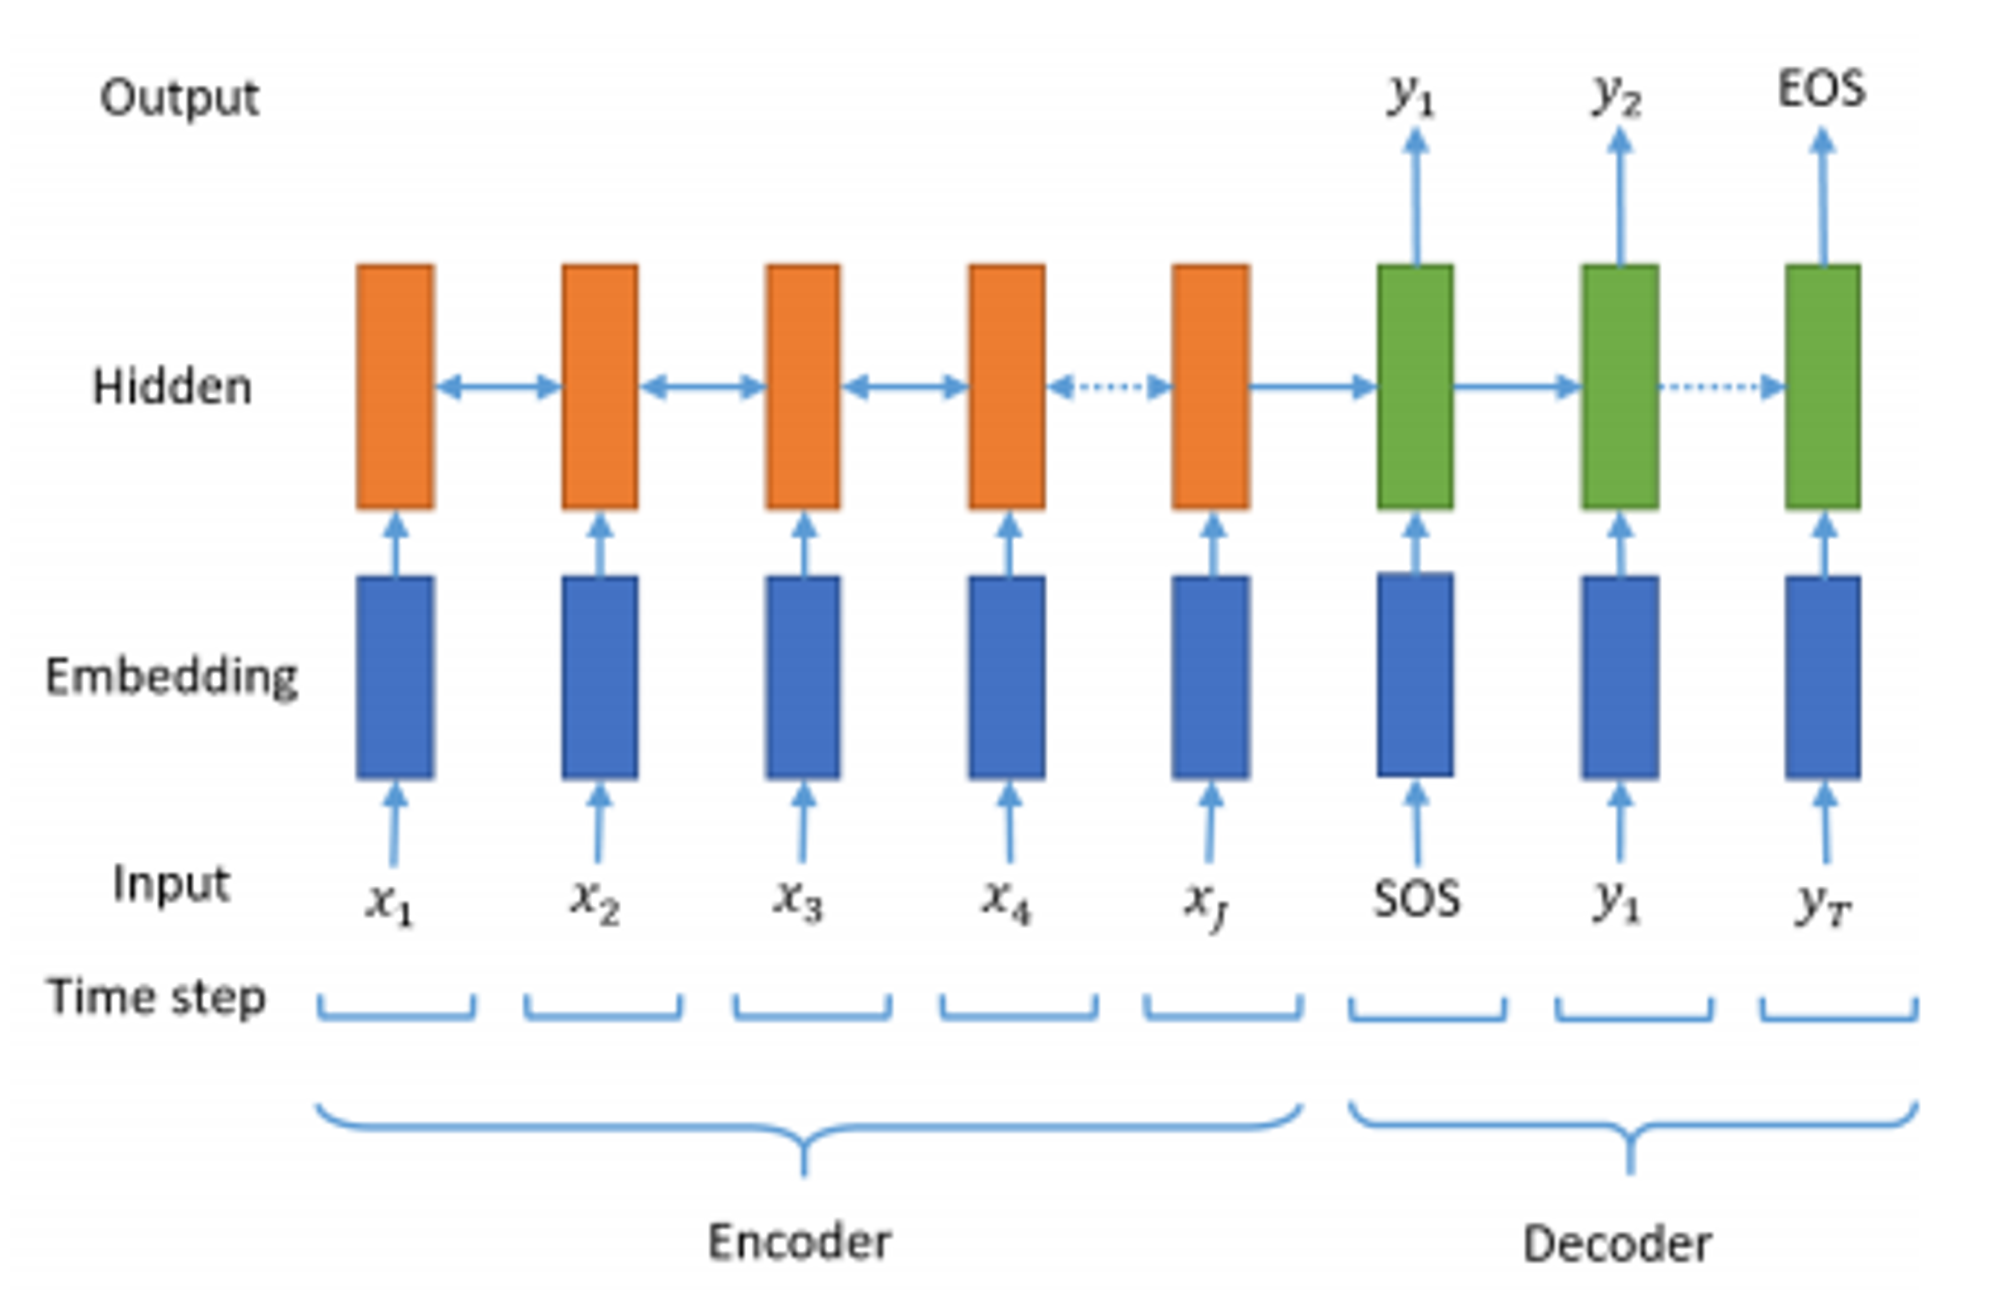
* LSTM (Long Short-Term Memory)의 hidden layer는 입력 데이터의 순서 정보와 그에 따른 의미를 유지하고 기억하는 레이어입니다. LSTM은 RNN (Recurrent Neural Network)의 한 종류로, 시퀀스 데이터에서 발생하는 장기 의존성 문제를 해결하기 위해 고안되었습니다. 이 hidden layer는 입력 데이터의 순서적인 특성을 고려하여 이전 시간 단계의 정보를 기억하고, 해당 정보를 다음 단계로 전달합니다. 이 과정을 통해 LSTM은 시퀀스 데이터의 패턴과 의미를 보다 잘 파악하고, 더 긴 기간 동안의 의존성을 학습할 수 있습니다. 이러한 능력으로 LSTM은 문장, 음성, 시계열 데이터 등과 같은 시퀀스 데이터를 처리하는 데 유용합니다.

* LSTM의 임베딩 레이어는 단어를 연속적인 공간에 매핑하는 역할을 합니다. 이는 단어를 밀집된 벡터로 변환하여 모델이 단어 간의 의미론적 관계를 이해하고, 이를 기반으로 입력 데이터를 처리할 수 있도록 돕습니다. 주로 텍스트 처리에서 사용되며, 텍스트를 숫자로 변환하는 기술인 워드 임베딩을 수행합니다. 단어들은 원-핫 인코딩 등의 희소한 형태에서 임베딩 레이어를 통해 밀집된 저차원 벡터로 표현됩니다. 이 벡터는 단어의 의미적 유사성을 캡처하여 모델이 단어의 상대적 의미를 학습할 수 있도록 돕습니다. 임베딩 레이어는 초기에 랜덤한 값을 갖지만, 모델 학습 과정에서 단어들 간의 관계와 의미를 파악하며 점차 업데이트되어 학습됩니다. 이러한 임베딩은 모델의 성능을 향상시키고 텍스트 데이터의 의미를 보다 효과적으로 이해할 수 있도록 도와줍니다.

**인코더 설계**
1. 임베딩 층 설정: 입력 시퀀스에 대한 임베딩을 수행합니다. Embedding 층은 입력 시퀀스의 각 단어를 임베딩 벡터로 변환합니다. src_vocab은 입력 데이터의 어휘 크기이며, embedding_dim은 임베딩 벡터의 차원을 나타냅니다.

2. 인코더 LSTM 레이어 구성: LSTM 셀을 이용하여 인코더를 구성합니다. 이 코드에서는 3개의 LSTM 레이어로 구성되어 있습니다. 각 레이어는 입력 시퀀스의 정보를 순차적으로 처리하고, return_sequences=True로 설정하여 모든 시간 단계에서 출력을 반환합니다. return_state=True로 설정하여 마지막 시간 단계의 은닉 상태와 셀 상태를 반환합니다. 또한, dropout 및 recurrent_dropout을 설정하여 과적합을 방지하기 위한 드롭아웃을 적용합니다.

3. 은닉 상태와 셀 상태 저장: 각 LSTM 레이어에서 얻은 마지막 시간 단계의 은닉 상태와 셀 상태를 각각 state_h1, state_c1, state_h2, state_c2, state_h3, state_c3에 저장합니다.

이렇게 구성된 인코더는 입력 시퀀스의 정보를 담은 상태 벡터와 셀 상태를 출력하며, 이러한 정보는 디코더로 전달되어 번역이나 요약 등의 작업을 수행하게 됩니다.

**hidden state와 cell state**

은닉 상태(hidden state)와 셀 상태(cell state)는 LSTM(Long Short-Term Memory) 레이어에서 사용되는 개념입니다.

* 은닉 상태 (Hidden State): LSTM의 각 시간 단계(time step)에서의 출력입니다. 현재 시간 단계의 입력과 이전 시간 단계의 은닉 상태를 기반으로 계산됩니다. 이는 현재까지의 입력 데이터를 통해 모델이 학습한 정보를 담고 있습니다.

* 셀 상태 (Cell State): LSTM이 정보를 기억하기 위해 사용하는 내부 메모리입니다. 각 시간 단계에서 셀 상태에는 입력 게이트, 삭제 게이트, 출력 게이트를 통해 정보가 얼마나 유지 또는 제거될지가 결정됩니다. 이러한 메커니즘을 통해 LSTM은 긴 시퀀스에서 중요한 정보를 유지하고 불필요한 정보를 잊어버립니다.

은닉 상태와 셀 상태는 LSTM이 시퀀스 데이터를 처리하고 이해하는 데 중요한 역할을 합니다. 각각 현재 시점의 출력과 내부적으로 기억하는 정보를 나타내며, 모델이 이를 통해 시퀀스의 패턴을 학습하고 예측하는 데 사용됩니다.

Hidden state의 크기를 늘리려면 hidden size를 늘리면 됩니다. Hidden size를 늘리면 모델이 각 시간 단계에서 더 많은 정보를 저장하고 더 복잡한 패턴을 학습할 수 있습니다. 하지만 더 큰 hidden size는 모델의 복잡성과 계산 비용을 늘리므로 적절한 크기를 선택하는 것이 중요합니다. 데이터의 복잡성과 모델의 용량 사이에 균형을 유지해야 합니다.

**Time step**

LSTM에서의 time step은 시퀀스 데이터를 구성하는 단계나 시간 단위를 나타냅니다. 시퀀스 데이터(예: 문장, 시계열 데이터)를 처리할 때, 각 단어나 각 시간 단계마다 LSTM에 데이터가 입력됩니다. 이때 입력되는 각 단계를 time step이라고 합니다. 예를 들어, 문장을 단어 단위로 처리할 경우 한 문장이 여러 time step으로 구성될 수 있습니다. 이러한 time step은 LSTM이 입력을 받고 출력을 생성하는 과정을 각각의 시간 단계로 처리하는데 사용됩니다.

In [40]:
# 함수형 API를 이용해서 인코더를 설계
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층 - 입력 시퀀스에 대한 임베딩을 수행한다.(Embedding 층은 입력 시퀀스의 각 단어를 임베딩 벡터로 변환 )
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs) # src_vocab은 입력 데이터의 어휘 크기, embedding_dim은 임베딩 벡터의 차원

# 각 LSTM 레이어는 입력 시퀀스의 정보를 순차적으로 처리한다.
# 인코더의 LSTM 1 - (return_sequences=True: 모든 시간 단계에서 출력을 반환, return_state=True: 마지막 시간 단계의 은닉 상태와 셀 상태를 반환
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4) # dropout 및 recurrent_dropout를 사용하여 과적합 방지
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4, recurrent_dropout = 0.4 )
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout = 0.4, recurrent_dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했다. hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터이다. 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해하면 된다. 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니다.

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였다. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있다. 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야 한다.

또한 LSTM은 dropout 뿐 아니라 recurrent dropout까지 사용할 수 있다. 일반적인 dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법이다.

반면 recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식이다. 즉 time step의 입력을 랜덤으로 생략해 주는 것이다. recurrent dropout은 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다고 한다.

아래 그림은 일반적인 dropout과, dropout과 recurrent dropout을 동시에 사용한 것을 시각적으로 표현한 것이다. 색이 있는 화살표는 dropout을 나타낸 것이다. (색이 다른 것은 다른 dropout mask를 사용했다는 표시인데, 지금은 그냥 넘어가도 된다.) 코드를 수정해서 LSTM에 dropout과 recurrent dropout을 모두 사용할 수 있다. 그렇게 되면 오른쪽 그림과 같은 형태가 된다. 참고로 dropout과 recurrent dropout을 모두 사용한 것을 Variational Dropout이라고도 한다.
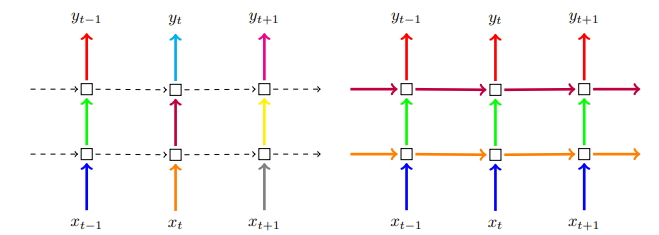
[dropout(왼쪽)과 dropout + recurrent dropout(오른쪽)]

참고로 recurrent dropout을 사용하면 아래와 같은 경고문이 뜬다.

WARNING:tensorflow:Layer lstm_15 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU

recurrent dropout을 사용할 시 cuDNN을 사용할 수 없어서 recurrent dropout을 사용하지 않을 때보다 학습 시간이 오래걸린다.

이제 디코더를 설계해보자.

In [41]:
# 디코더 설계
decoder_inputs = Input(shape=(None,)) # 시퀀스 길이를 가변적으로 받을 수 있도록 None으로 설정

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하다. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 한다.

디코더의 출력층을 설계해보자.

In [42]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 한다. 그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있다.

지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq이다. 그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있다. 바로 **어텐션 메커니즘**이다.

### 어텐션 메커니즘
---
어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻이다. 어텐션 함수를 설계해보는 것은 다음 기회로 미루기로 하고, 여기서는 TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 배워보자. 참고로 여기서 사용하는 어텐션 함수는 Bahdanau 스타일의 어텐션이다. 이 어텐션에 대한 자세한 설명은 텐서플로우 홈페이지를 참고하자.

* https://www.tensorflow.org/api_docs/python/tf/keras/layers/AdditiveAttention

아래와 같이 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정해 보자.

In [43]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있다.

## 모델 훈련하기
---
설계한 모델을 가지고 훈련을 진행해보자.

In [44]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 206s 956ms/step - loss: 2.7039 - val_loss: 2.4182
Epoch 2/50
201/201 [==============================] - 186s 926ms/step - loss: 2.3682 - val_loss: 2.2560
Epoch 3/50
201/201 [==============================] - 187s 929ms/step - loss: 2.2156 - val_loss: 2.1392
Epoch 4/50
201/201 [==============================] - 186s 926ms/step - loss: 2.1058 - val_loss: 2.0597
Epoch 5/50
201/201 [==============================] - 185s 919ms/step - loss: 2.0254 - val_loss: 2.0151
Epoch 6/50
201/201 [==============================] - 185s 923ms/step - loss: 1.9639 - val_loss: 1.9732
Epoch 7/50
201/201 [==============================] - 186s 927ms/step - loss: 1.9114 - val_loss: 1.9396
Epoch 8/50
201/201 [==============================] - 184s 918ms/step - loss: 1.8662 - val_loss: 1.9184
Epoch 9/50
201/201 [==============================] - 186s 924ms/step - loss: 1.8251 - val_loss: 1.9025
Epoch 10/50
201/201 [==============================] - 185s 922m

'조기 종료'를 뜻하는 EarlyStopping은 특정 조건이 충족되면 훈련을 멈추는 역할을 한다.

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
위 코드에서는 val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정돼 있다. EarlyStopping이 작동한다면 epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있다.

EarlyStopping에 대한 자세한 내용은 아래 링크를 참고하자! 자주 쓰이는 도구이니 자세히 알아두면 매우 도움이 될 것이다.

* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

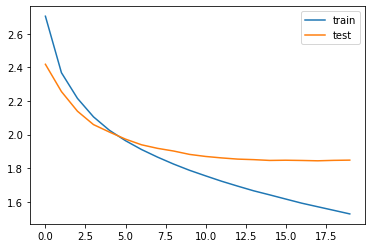

In [45]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 인퍼런스 모델 구현하기
---
테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둔다.

In [46]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다.

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 한다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계한다.

In [47]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


어텐션 메커니즘을 사용하는 출력층을 설계한다.

In [48]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만든다.

In [49]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


##  모델 테스트하기
---
테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편하다. 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어보자. 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 것이다.

In [50]:
# seq2text 함수처럼 요약문의 정수 시퀀스를 텍스트로 변환하는 seq2summary 함수 코드를 작성
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교해보자.

In [51]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : quality street chocolates xmas tradition many families must holidays become difficult find us last years thank god amazon try bottle get favorites friends addicted 
실제 요약 : my favorite 
예측 요약 :  great gift


원문 : started using months ago love really baked chicken well seasoned tasty dish first tried fish used much realizing sodium content next time adjusted accordingly added pat butter ended delicious recommend staple spice cabinet 
실제 요약 : so good on baked chicken fish 
예측 요약 :  great for cooking


원문 : best fruit chews ever flavor texture great son last summer first time boy scout ranch new mexico course said real treat glad found amazon well worth price great value 
실제 요약 : yummy 
예측 요약 :  great product


원문 : never tasted bagel snacks awful tasting bad bought poppy seed flavor thought fishy flavor like say twice baked burnt yuck least pigs like snack 
실제 요약 : these are yuck 
예측 요약 :  not bad


원문 : tonight dinner made gluten free sauce meatballs one could tell difference brand

예측 요약 :  best chai tea


원문 : giving dental chews little pomeranian years vet always says great job brushing teeth gums although chewies job highly recommended 
실제 요약 : best chews ever 
예측 요약 :  great product


원문 : stopped able find large quantities locally glad amazon vendors selling great price 
실제 요약 : greenies 
예측 요약 :  great product


원문 : switch people want drink one word explain drink straight great 
실제 요약 : switch black cherry 
예측 요약 :  great taste


원문 : delicious authentic tasting maple syrup come across year old loves milk calls whole drink maple syrup thats much likes stuff sell costco feels like sugar water compared product disappointed 
실제 요약 : the real stuff 
예측 요약 :  delicious


원문 : pup experienced allergies forms itching dog foods cheap buy anywhere food crazy preservatives cause health problems pets food works wonders reducing allergies dog loves food message approved 
실제 요약 : great allergy sensitive dog food dogs love it 
예측 요약 :  great food for my dog


원문 : got e

많은 결과가 출력이 되는데, 기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들이 보인다. 심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 하고 있다. 워드 임베딩과 RNN의 콜라보로 이뤄낸 신기한 성과이다.

물론 슬프게도 그다지 좋지 않은 요약의 예도 꽤나 보이기도 한다. 성능을 개선하기 위해서는 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있고, 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 같은 여러 개선 방안들이 존재한다. 이런 방안들에 대해서도 향후 살펴보게 될 것이다.

## 추출적 요약 해보기
---
앞서 seq2seq를 통해서 추상적 요약을 진행해봤다.. 그런데 텍스트 요약에는 추상적 요약 외에도 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는 추출적 요약 방법도 있었다.

**추출적 요약 방법**: 추출적 요약은 원문에서 중요한 핵심 문장 또는 단어를 뽑아 구성된 요약문을 만드는 방식이다. 그래서 생성된 문장이나 단어는 원문에 포함되어 있기 때문에, 단점으로 언어 표현 능력이 제한되어 생성된 문장이 매끄럽지 않을 수 있다. 대표적인 알고리즘으로는 TextRank가 있다.

패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 실습을 해볼 수 있다. 영화 매트릭스 시놉시스를 요약해보면서 summarize 사용법을 익혀보자.

### 패키지 설치
---
클라우드의 경우 이미 summa 가 설치돼 있다. 확인해보고 싶으시면 아래 명령어를 Cloud Shell에서 실행해보자.
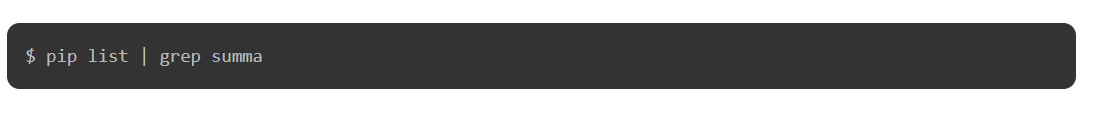

### 데이터 다운로드하기
---


In [52]:
import requests
from summa.summarizer import summarize

In [53]:
# 매트릭스 시놉시스를 다운로드
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

text에는 매트릭스 시놉시스가 문자열로 저장돼 있다. 출력 결과가 아주 길기 때문에 일부만 출력해보고, 잘 저장이 되었는지 확인해보자.

In [54]:
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

## summarize 사용하기
---
Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아보자.

* text (str) : 요약할 테스트.
* ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
* words (int or None, optional) – 출력에 포함할 단어 수. 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
* split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행한다. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다. 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여보자. 원문의 0.005%만을 출력하도록 설정했다.

In [55]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


만약 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True로 하면 된다.

In [56]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']


단어의 수로 요약문의 크기를 조절할 수도 있다. 단어를 50개만 선택하도록 해보자.

In [57]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
